<img style="float: left;" src="images/unige_csd.png" alt="drawing" width="200"/>

# <center>Imagerie Numérique 2023 Automne</center>

<center>October 26, 2023</center>

# <center><ins>TP Class N°3 - Image acquisition and sensing</ins></center>

#### *Instructions :*  

* This TP should be completed and uploaded on Moodle before **Thursday 9 November 2023, 23h59**.
* The name of the file you upload should be **TP3_name_surname.ipynb**.
* If you need to include attached files to you TP, please archive them together in a folder named **TP3_name_surname.zip**.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from numpy import shape, uint8 as u8, uint32 as u32, uint64 as u64, float64 as f64
from numpy.typing import NDArray
from PIL import Image
import skimage as sk
import skimage.color as skc
import matplotlib.image as mpim
from copy import deepcopy

FIG_SIZE = (20, 10)


def imread(path: str, dtype: type = u8, grayscale: bool = False) -> NDArray:
    """
    Load the image at given path into a numpy array
    @param path: path to image (relative to this file)
    @param dtype: if float, returned image will be in the [0, 1] range, else in [0, 255] (defaults to uint8)
    @param grayscale: whether to load image as grayscale or not
    @return: NDArray of shape (m, n, 3) if grayscale is False, else (m, n)
    """
    img: Image = Image.open(path)
    if grayscale: img = img.convert('L')
    out = np.array(img)
    # does not check that max is indeed 1 because it would be too costly
    is_float = np.issubdtype(out.dtype, np.floating)
    if np.issubdtype(dtype, np.floating) and not is_float: out = f64(out / 255.)
    return out


def imshow_gray(data, show=True, axis=True):
    plt.imshow(data, cmap="gray")
    plt.axis("on" if axis else "off")
    if show: plt.show()


def imshow(data, show=True, axis=True):
    plt.imshow(data)
    plt.axis("on" if axis else "off")
    if show: plt.show()


def MSE(im1, im2):
    return np.sum((im1 - im2) ** 2) / (im1.shape[0] * im1.shape[1])

In [93]:
def image_plot(idx: int, data, title=None, col_nb=4, row_nb=1,  gray=True):
    plt.subplot(row_nb, col_nb, idx + 1)
    plt.title(title if title else "")
    if gray:
        imshow_gray(data, show=False, axis=False)
    else:
        imshow(data, show=False, axis=False)


# Exercise 1

Have a look at the following image :

![photography main parameters](images/photography_main_parameters.jpg)

Using these illustrations, explain the concepts of Aperture, Shutter speed and ISO. How are they built in a modern Digital Single-Lens Reflex ?

# Exercise 2

(a) In a 100 × 100 RGB image each pixel is represented by 256 levels of intensity. How many bytes are needed to store these image without any compression?

The image needs $\log_2(256)$ bits to render the 256 levels i.e. 8bits. 
Its an rgb images so each pixel has 3 of those, hence 3B by pixel.
The image has 100x100 pixels, so it needs $100 \times 100 \times 3 = 30000\ Bits$ i.e. 30KB.

(b) In a 100 × 100 gray-scale image each pixel is represented by 4 levels of intensity. How many bytes are needed to store these image without any compression?

Same computation:
The image needs $\log_2(4)$ bits to render the 4 levels i.e. 2b py pixel.
$100 \times 100 \times 2 = 20000\ bits\ $ i.e. 2.5KB.


(c) Generate a $100 \times 100$ RGB image constituted of uniform random noise (use *numpy.random.uniform()*). Save it as a png file using *plt.imsave()*. Comment on the size of the file.

**Hint :** In order to understand what is going on, you might want to load the image again in Python using *plt.imread()*

In [36]:
from os import stat

noise_img = np.random.uniform(0, 1, (100, 100, 3))
plt.imsave("images/noise.png", noise_img)
stat("images/noise.png").st_size

35377

The size of the image is 35KB, which is approximately the same as what we computed in (a).

(d) Generate a $100 \times 100$ grayscale gradient image (see TP1 ex 2). Save it again as a png file. Comment.

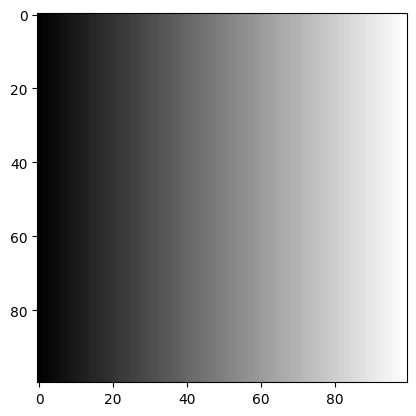

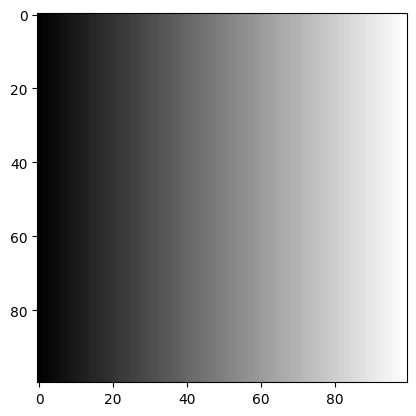

In [37]:
linear_gradient = np.tile(np.linspace(0, 255, 100, dtype=u8), (100, 1))
imshow_gray(linear_gradient)
plt.imsave("images/gray_dient.png", linear_gradient, cmap="gray")
imshow_gray(plt.imread("images/gray_dient.png"))


In [38]:
stat('images/gray_dient.png').st_size


459


We get back the same image but the size of the grayscale image is 459B i.e. 0.46KB, which is much smaller than the RGB image.


# Exercise 3

(a) Explain the difference between sampling and quantization.

- Sampling is the discretization of x axis 
- while quantization is the discretization of y axis

By discretization on x axis, we mean the process of breaking up a continuous signal into a discrete signal.
And by discretization on y axis, we mean the process of breaking up a larget set of value into a smaller one.

(b) You are given a continuous signal  *$f(x) = sin(x)+\frac{1}{10} cos(10x)$* over the interval *$0 \leq  x \leq 8 \pi$* and *$-1.1 \leq y \leq 1.1$*.

Using *np.linspace()* and *plt.plot()*, visualize this continuous signal on the given interval with a high number of samples.

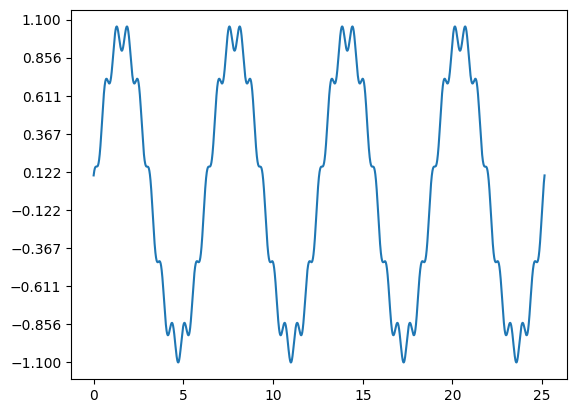

In [39]:
def f(x):
    return np.sin(x) + 0.1 * np.cos(10 * x)


num_sample = u64(10e6)
itv_x = np.linspace(0, 8 * np.pi, num_sample)
itv_y = np.linspace(-1.1, 1.1, 10)

#x, y = np.meshgrid(itv_x, itv_y)
plt.yticks(itv_y)
plt.plot(itv_x, f(itv_x))
plt.show()


(c) Choose various values of sampling and quantization for this signal and plot the results on a grid of subplots, varying both parameters. Comment on the quality of the approximation.

**Hint :** Use *np.linspace()* and *np.digitize()* to generate the correct sampling and quantizations, try different values of samples and bins.

> Answer here

# Exercise 4

(a) Generate a gradient image like the one represented in Figure 1. Encode the image with $k=7, 5, 3, 2, 1$ bits (Theme 3, page 109). Display and explain the results.

<figure>
<center>
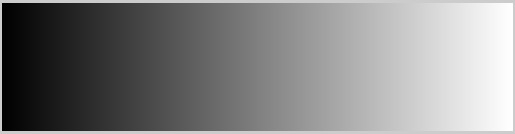
<figcaption>Figure 1: Gradient image</figcaption></center>
</figure>

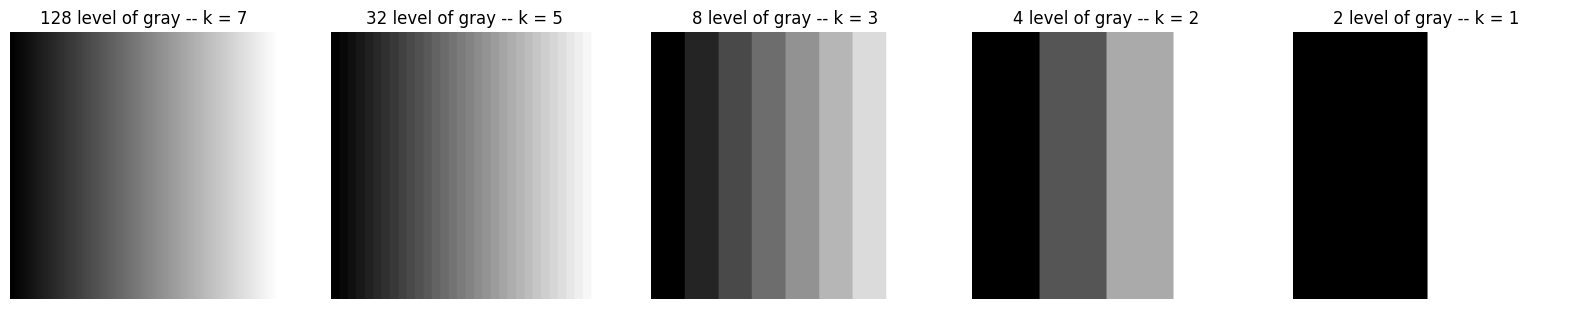

In [81]:
dim = 500
linear_gradient = np.tile(np.linspace(0, 255, dim, dtype=u8), (dim, 1))

ks = [7, 5, 3, 2, 1]

plt.figure(figsize=FIG_SIZE)
for i, k in enumerate(ks):
    # "downgrading" image by shifting by 1 or more power of 2 the max gray value
    data = linear_gradient >> 8 - k
    image_plot(i, data, f"{2 ** k} level of gray -- k = {k}", col_nb=5)
plt.show()

We see that when we have K bits for the gray, instead of having a continuous grayscal as we might seem to see, we have in fact $2^k$ strips from black to white ($2^k$ colors)

(b) Do the same for the grayscale image *lena.png*.  Display the obtained results.

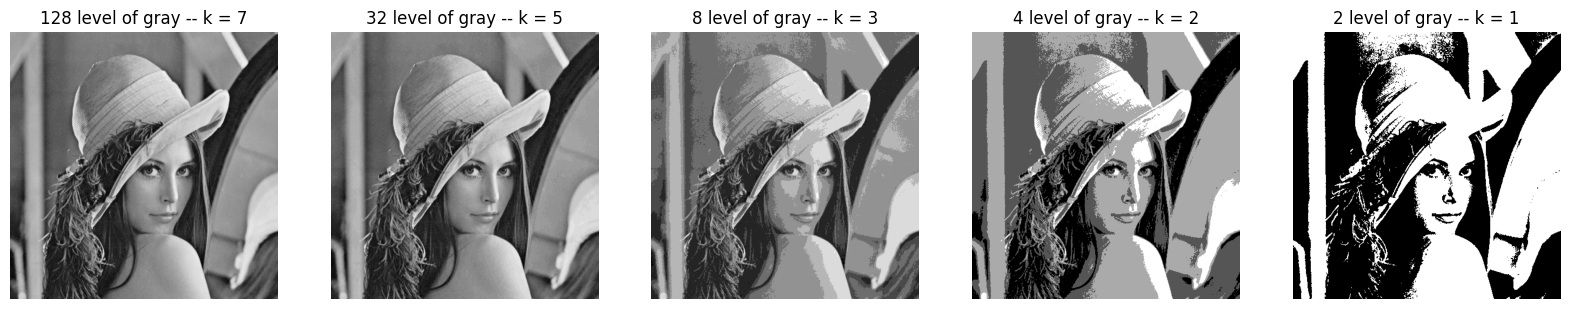

121

In [82]:
plt.figure(figsize=FIG_SIZE)
lena_orig = imread("images/lena.png", grayscale=True, dtype=u8)
ks = [7, 5, 3, 2, 1]

for i, k in enumerate(ks):
    image_plot(i, lena_orig >> 8 - k, f"{2 ** k} level of gray -- k = {k}", col_nb=5)
plt.show()

We get the same result as in (a) but with the lena image.
But purely on an "appearance" point of view, we start to see real non-neglectable "damage" only from approximately k=3, which is dividing the original number by 32.

I.e. We can divide the number of gray levels by 32 before the image starts to look ugly. Which is surprisingly high.

# Exercise 5

(a) Write the function that measures PSNR value between two images (see Theme 2, Lecture notes).

In [83]:
def PSNR(img1: NDArray, img2: NDArray) -> f64:
    mse = MSE(img1, img2)
    np.max(img1, img2)
    return 10 * np.log10(np.max(np.stack((img1, img2))) ** 2 / mse)

(b) Read the image *lena.png* and convert it to grayscale with dynamic range in $[0,1]$. Create 10 noisy lena images by adding a zero-mean white Gaussian noise with standard deviation $\sigma = 0.1$.

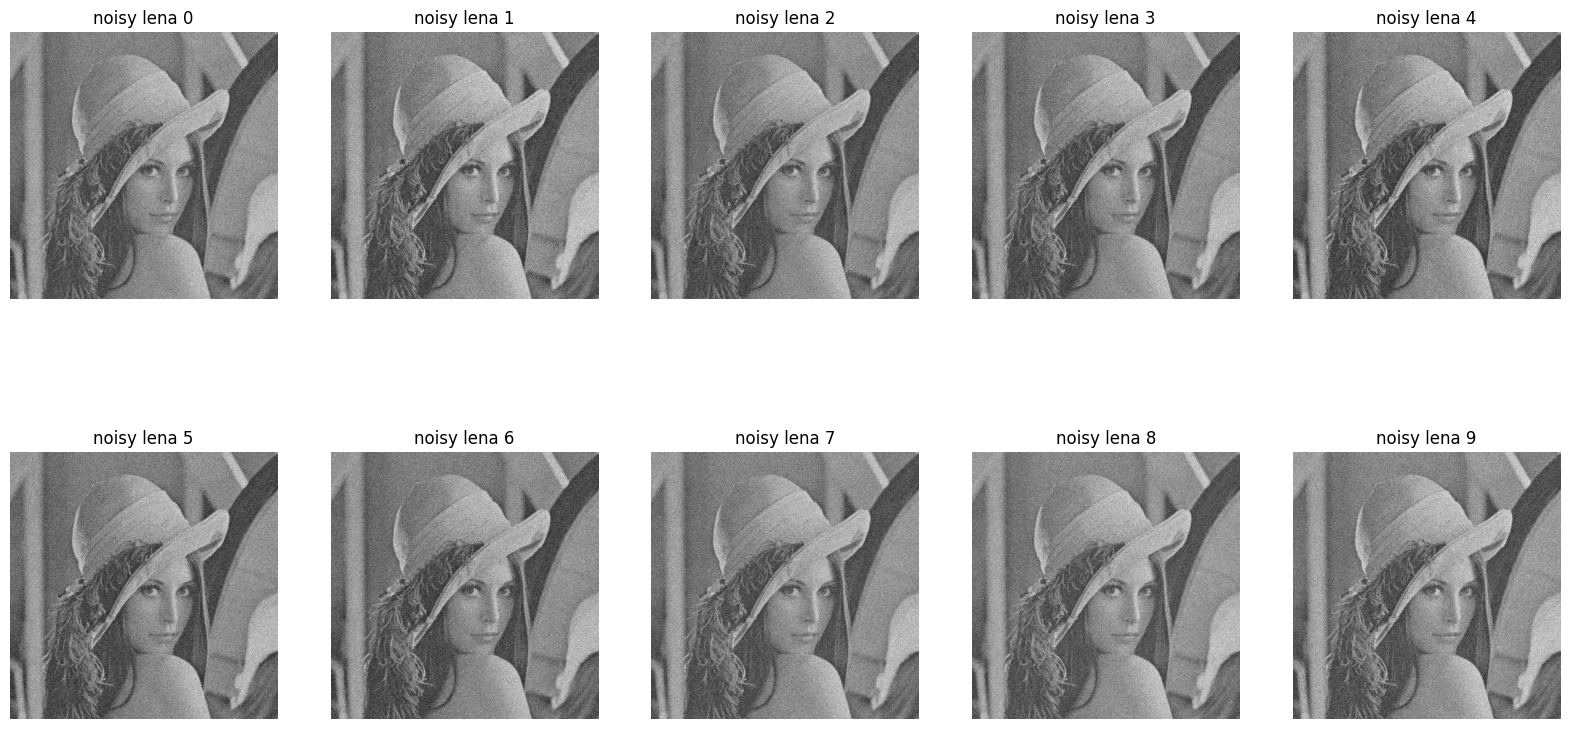

In [94]:
lena = imread("images/lena.png", grayscale=True, dtype=f64)


def add_white_gaussian_noise(img: NDArray) -> NDArray:
    return img + np.random.normal(0, 0.1, img.shape)


noisy_lenas = [add_white_gaussian_noise(lena) for _ in range(10)]
plt.figure(figsize=FIG_SIZE)
for i, lena in enumerate(noisy_lenas):
    image_plot(i, lena, f"noisy lena {i}", col_nb=5, row_nb=2)
plt.show()


(c) Report the average PSNR value between the original and noisy images.
> **Hint** Measure the PSNR between the original and each noisy image, then compute the mean of the results.

(d) Perform image denoising by using the so named _frame averaging_ approach.
> **Hint** Perform a pixel-wise summation of all noisy images. Divide the obtained sum image by the number of images in the summation.

(e) Measure the PSNR between the original and the denoised image. Comment the obtained result in the light of the previous computations. Explain when (under which condition) _frame averaging_ is successful and when it does not work.

> -- your answer --

# Exercise 6

You are given a pair of two images (reference and noisy) from the [RENOIR dataset](http://ani.stat.fsu.edu/~abarbu/Renoir.html).

<p align="center">
<img src="images/reference.bmp" alt="reference" width="300"/>
<img src="images/noisy.bmp" alt="noisy" width="300"/>
</p>

(a) Visualize each color channels for both images (a grayscale display of each channel). Are all channels equally affected by the noise? Justify your answer based on the _PSNR_ or _MSE_.

> --your answer --

(b) Try to decrease the noise by downsampling the image 2 times and then upsampling it back to its original size. Apply this method to the RGB noisy image. Measure the PSNR between the reference and the obtained denoised images.
> **Hint** To measure the PSNR between RGB images, compute the PSNR for each color channel and then take the average value.

(c) Convert both images to grayscale and redo part (b). Explain why the PSNR is higher for the denoised grayscale image.
> **Hint**: The reason is linked to exercise 4. Explain why.

> --your answer --

(d) What other methods could you suggest to improve the noisy image quality?

> --your answer --

___